# GHZ state in Rydberg atoms

In this tutorial, we describe the preparation of the $N$-particle GHZ state

$$|\text{GHZ}_N\rangle = \frac{1}{\sqrt{2}}\left(|0101\dots\rangle + |1010\dots\rangle\right),$$
in a linear chain of Rydberg atoms, as described in [Omran et al. 2019](https://www.science.org/doi/10.1126/science.aax9743).


1D array of Rydberg atoms driven by global pulses can be desribed with the following Hamiltonian
$$H(t) =  \frac{\Omega(t)}{2}\sum_{i = 1}^N\sigma_x^{(i)} - \sum_{i = 1}^N\Delta_i(t)n_i + \sum_{i < j}\frac{V}{|i-j|^6}n_in_j,$$
where $n_i = |1\rangle\langle1|_i$ are the excited state occupation operators. $\Delta_i(t) = \Delta(t) + \delta_i$ is the local effective detuning set by the Rydberg laser and the local light shift. We set $\delta_i = \delta_e$ to be non-zero only on atoms 1 and $N$.

In [1]:
using Sisyphus
using QuantumOptics
using Flux, DiffEqFlux
using Plots
using ProgressMeter
using Random

ProgressMeter.ijulia_behavior(:clear);

In [2]:
T = 1.1 # in μs
V = 2π * 24.0 # in MHz
δe = -2π * 4.5 # in MHz
n_atoms = 4

bs = SpinBasis(1//2)
sx = sigmax(bs)
ni = 0.5*(identityoperator(bs) + sigmaz(bs))

bsys = tensor([bs for i in 1:n_atoms]...)
H0 = V*sum([embed(bsys, [i, j], [ni, ni])/abs(i-j)^6  for i in 1:n_atoms for j in i+1:n_atoms])
H0 -= δe*sum([embed(bsys, [i], [ni]) for i in [1, n_atoms]])
H1 = 0.5*sum([embed(bsys, [i], [sx]) for i in 1:n_atoms])
H2 = -sum([embed(bsys, [i], [ni]) for i in 1:n_atoms]);

We provide initial guesses for our pulses.

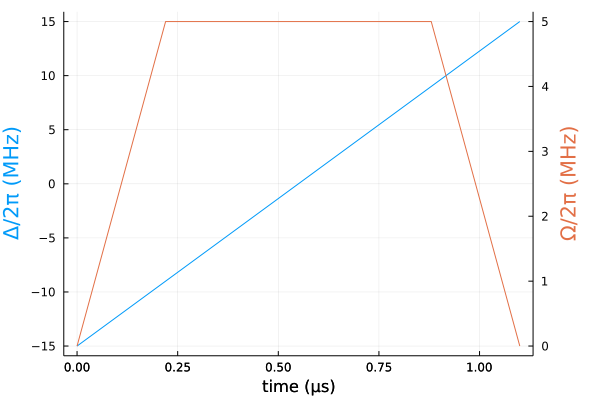

In [3]:
Ω₀(t) = 2π * min(5.0, 25.0 * t / T, 25.0 * (T - t) / T)
Δ₀(t) = 2π * (30.0 * t / T - 15.0)

ts = collect(0.0:0.001:T)

blue = theme_palette(:auto).colors.colors[1]
red = theme_palette(:auto).colors.colors[2]
plot(ts, Δ₀.(ts)/2π, ylabel="Δ/2π (MHz)", color=blue, yguidefont = font(blue), legend=false)
plot!(Plots.twinx(), ts, Ω₀.(ts)/2π, ylabel="Ω/2π (MHz)", color=red, yguidefont = font(red), legend=false)
plot!(xlabel="time (μs)", right_margin = 15Plots.mm)

In [4]:
Ω(p, t) = piecewise_const_interp(p[begin:length(p)÷2], t; t0=0.0, t1=T)
Δ(p, t) = piecewise_const_interp(p[length(p)÷2+1:end], t; t0=0.0, t1=T)

n_params = 30
ts = collect(0.0:T/n_params:T)
θ = vcat([Ω₀((ts[i+1] + ts[i])/2) for i=1:n_params], [Δ₀((ts[i+1] + ts[i])/2) for i=1:n_params]);

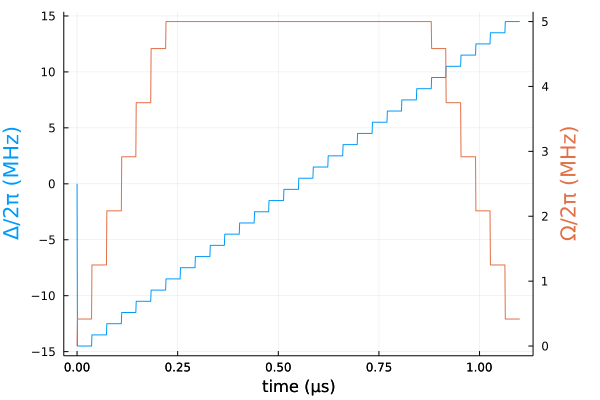

In [5]:
ts = collect(0.0:0.001:T)

blue = theme_palette(:auto).colors.colors[1]
red = theme_palette(:auto).colors.colors[2]
plot(ts, [Δ(θ, t)/2π for t in ts], ylabel="Δ/2π (MHz)", color=blue, yguidefont = font(blue), legend=false)
plot!(Plots.twinx(), ts, [Ω(θ, t)/2π for t in ts], ylabel="Ω/2π (MHz)", color=red, yguidefont = font(red), legend=false)
plot!(xlabel="time (μs)", right_margin = 15Plots.mm)

In [6]:
function GHZ_state(n_atoms)
    state = tensor([isodd(i) ? spindown(bs) : spinup(bs) for i=1:n_atoms]...) +
            tensor([isodd(i) ? spinup(bs) : spindown(bs) for i=1:n_atoms]...)
    state/sqrt(2.0)
end 

ground_state(n_atoms) = tensor([spindown(bs) for i in 1:n_atoms]...)

cost = CostFunction((x, y) -> 1.0 - abs2(x'*y))
trans = StateTransform(ground_state(n_atoms) => GHZ_state(n_atoms))
H = Hamiltonian(H0, [H1, H2], (p, t) -> [Ω(p, t), Δ(p, t)]);

In [7]:
tout, psit = schroedinger_dynamic(ts, ground_state(n_atoms), H, θ);

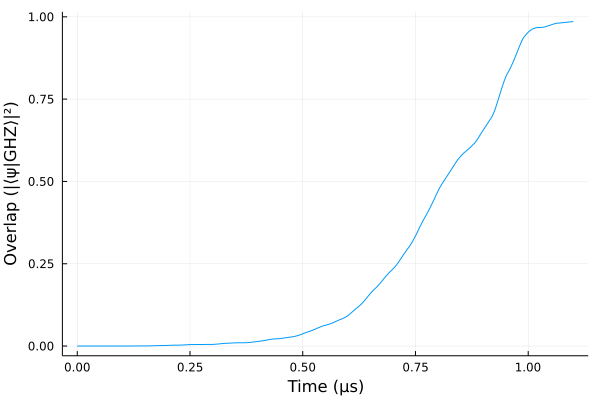

In [8]:
plot(ts, real(expect(dm(GHZ_state(n_atoms)), psit)))
plot!(xlabel="Time (μs)", ylabel="Overlap (|⟨ψ|GHZ⟩|²)", legend=false)

In [9]:
println("Fidelity: ", real(expect(dm(GHZ_state(n_atoms)), psit[end])))

Fidelity: 0.9856598145164646


In [10]:
prob = QOCProblem(H, trans, (0.0, T), cost)
sol = solve(prob, θ, ADAM(0.2); abstol=1e-6, reltol=1e-6);

Progress: 100%|█████████████████████████████████████████| Time: 0:05:16
  distance:     4.671056424032649e-5
  constraints:  0.0


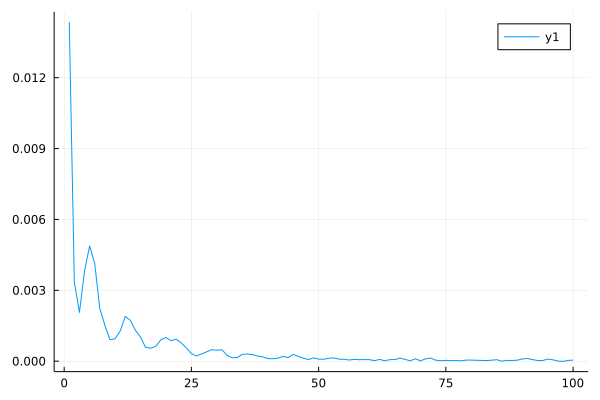

In [11]:
plot(sol.distance_trace)

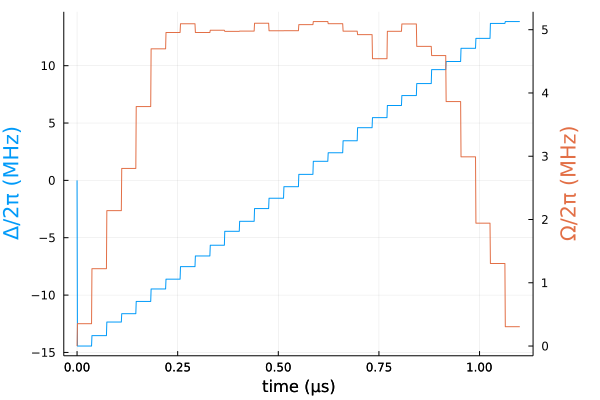

In [12]:
ts = collect(0.0:0.001:T)

blue = theme_palette(:auto).colors.colors[1]
red = theme_palette(:auto).colors.colors[2]
plot(ts, [Δ(sol.params, t)/2π for t in ts], ylabel="Δ/2π (MHz)", color=blue, yguidefont = font(blue), legend=false)
plot!(Plots.twinx(), ts, [Ω(sol.params, t)/2π for t in ts], ylabel="Ω/2π (MHz)", color=red, yguidefont = font(red), legend=false)
plot!(xlabel="time (μs)", right_margin = 15Plots.mm)

In [13]:
tout, psit = schroedinger_dynamic(ts, ground_state(n_atoms), H, sol.params);

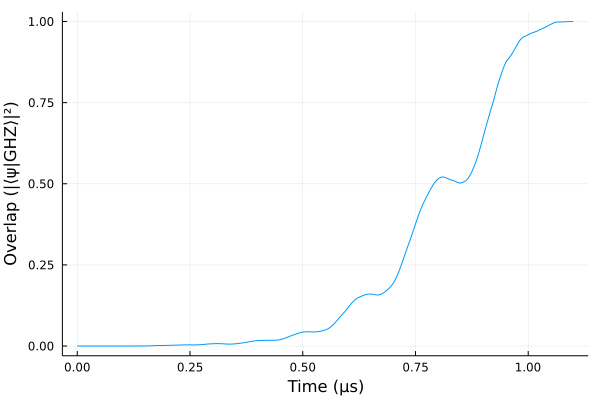

In [14]:
plot(ts, real(expect(dm(GHZ_state(n_atoms)), psit)))
plot!(xlabel="Time (μs)", ylabel="Overlap (|⟨ψ|GHZ⟩|²)", legend=false)

In [15]:
println("Fidelity: ", real(expect(dm(GHZ_state(n_atoms)), psit[end])))

Fidelity: 0.9999463779819884
